In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb

In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
holidays = pd.read_csv('../data/holidays_events.csv')
oil = pd.read_csv('../data/oil.csv')
stores = pd.read_csv('../data/stores.csv')
transactions = pd.read_csv('../data/transactions.csv')

### Train

In [3]:
train.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

### Holidays

In [4]:
holidays.isnull().sum()

date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

### Oil

In [5]:
oil.isnull().sum()

date           0
dcoilwtico    43
dtype: int64

In [6]:
# Back fill oil price since oil price does not change drastically day-to-day
oil['dcoilwtico'] = oil['dcoilwtico'].bfill()
oil.isnull().sum()

date          0
dcoilwtico    0
dtype: int64

### Stores

In [7]:
stores.isnull().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

### Transactions

In [8]:
transactions.isnull().sum()

date            0
store_nbr       0
transactions    0
dtype: int64

### Convert Dates to datetime

In [9]:
for df in [train, test, holidays, oil, transactions]:
    df['date'] = pd.to_datetime(df['date'])

In [10]:
for df in [train, test]:
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['weekday'] = df['date'].dt.weekday

### Check for nulls

In [11]:
print("=== Missing train values ===")
print(train.isnull().sum())
print("=== Missing test values ===")
print(test.isnull().sum())
print("=== Missing holidays values ===")
print(holidays.isnull().sum())
print("=== Missing oil values ===")
print(oil.isnull().sum())
print("=== Missing stores values ===")
print(stores.isnull().sum())
print("=== Missing transaction values ===")
print(transactions.isnull().sum())

=== Missing train values ===
id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
year           0
month          0
day            0
weekday        0
dtype: int64
=== Missing test values ===
id             0
date           0
store_nbr      0
family         0
onpromotion    0
year           0
month          0
day            0
weekday        0
dtype: int64
=== Missing holidays values ===
date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64
=== Missing oil values ===
date          0
dcoilwtico    0
dtype: int64
=== Missing stores values ===
store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64
=== Missing transaction values ===
date            0
store_nbr       0
transactions    0
dtype: int64


### Merge store data into train and test

In [12]:
train = train.merge(stores, on='store_nbr', how='left')
test = test.merge(stores, on='store_nbr', how='left')

### EDA

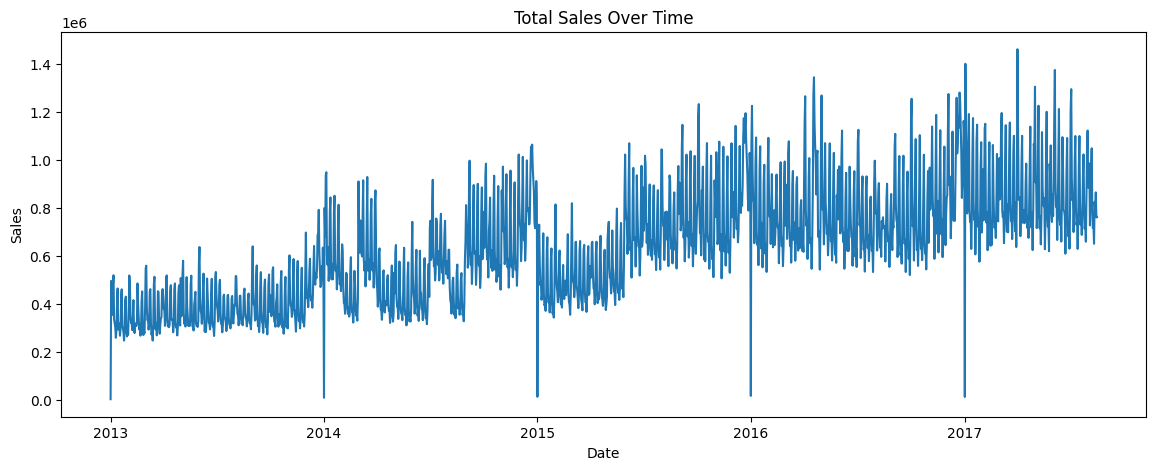

In [13]:
plt.figure(figsize=(14,5))
daily_sales = train.groupby('date').sales.sum()
sns.lineplot(x=daily_sales.index, y=daily_sales.values)
plt.title('Total Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

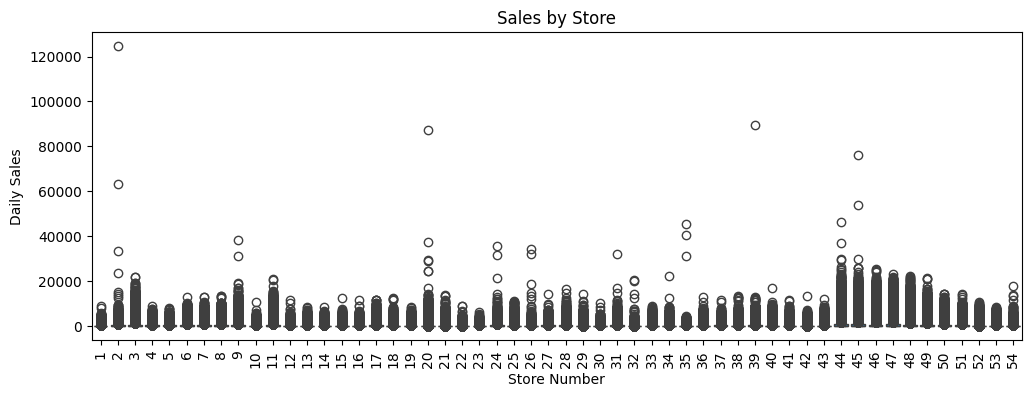

In [14]:
plt.figure(figsize=(12,4))
sns.boxplot(x='store_nbr', y='sales', data=train)
plt.title('Sales by Store')
plt.xlabel('Store Number')
plt.ylabel('Daily Sales')
plt.xticks(rotation=90)
plt.show()

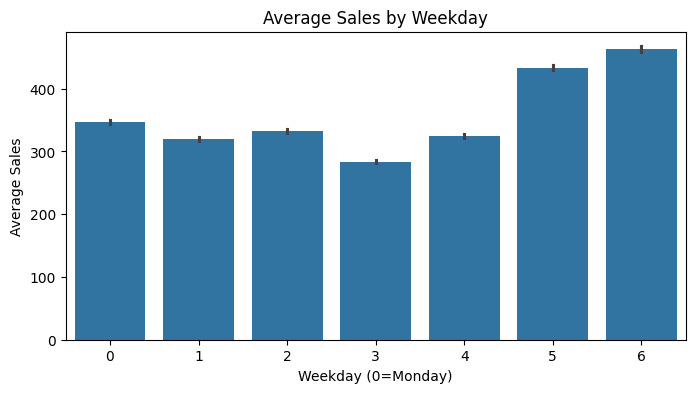

In [15]:
plt.figure(figsize=(8,4))
sns.barplot(x='weekday', y='sales', data=train)
plt.title('Average Sales by Weekday')
plt.xlabel('Weekday (0=Monday)')
plt.ylabel('Average Sales')
plt.show()

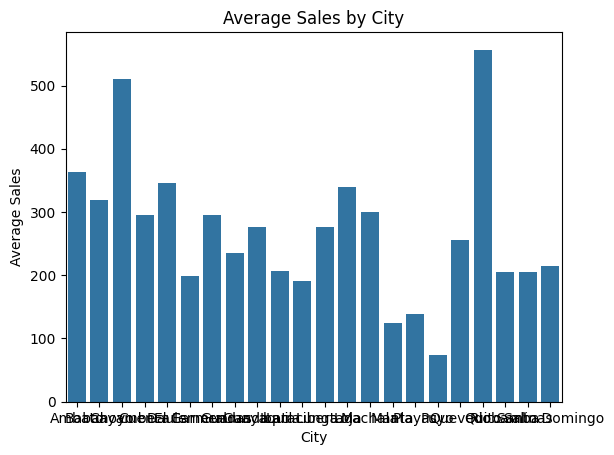

In [16]:
sns.barplot(x='city', y='sales', data=train.groupby('city')['sales'].mean().reset_index())
plt.title('Average Sales by City')
plt.xlabel('City')
plt.ylabel('Average Sales')
plt.show()

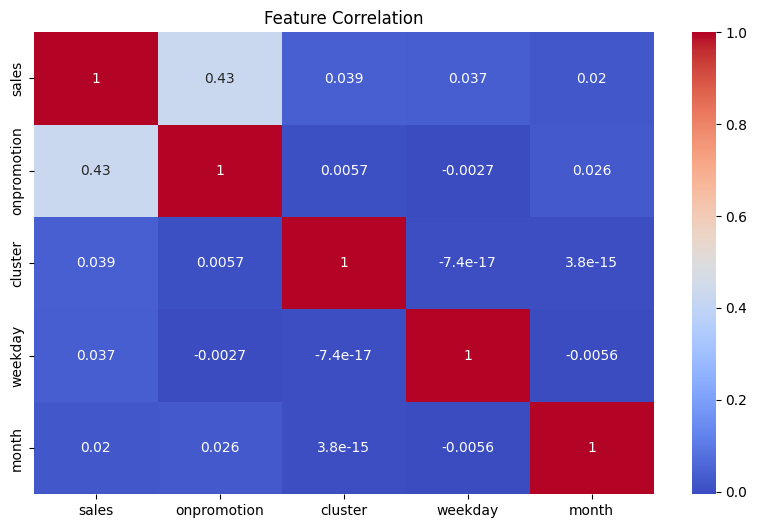

In [17]:
plt.figure(figsize=(10,6))
corr = train[['sales', 'onpromotion', 'cluster', 'weekday', 'month']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Feature Correlation')
plt.show()

### Encoding categorical columns

In [18]:
train.head()

,id,date,store_nbr,family,sales,onpromotion,year,month,day,weekday,city,state,type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,2013,1,1,1,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.0,0,2013,1,1,1,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.0,0,2013,1,1,1,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.0,0,2013,1,1,1,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.0,0,2013,1,1,1,Quito,Pichincha,D,13


In [19]:
cat_cols = ['family', 'city', 'state', 'type']

for col in cat_cols:
    combined = pd.Categorical(pd.concat([train[col], test[col]]))
    train[col] = pd.Categorical(train[col], categories=combined.categories).codes
    test[col] = pd.Categorical(test[col], categories=combined.categories).codes

In [20]:
print(train[cat_cols].dtypes)
print(test[cat_cols].dtypes)

family    int8
city      int8
state     int8
type      int8
dtype: object
family    int8
city      int8
state     int8
type      int8
dtype: object
